# LOADING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt

from keras.layers import Conv2D 
from keras.layers import Dense
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dropout 
from keras.models import Sequential
from keras.models import load_model
from keras import regularizers
from keras import backend as K

from keras import models
from keras.preprocessing import image 

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# DATA LECTURE

###### raw file upload

In [2]:
base_dir = '/home/reda/Téléchargements/datasets/IdemiaExerciceML/'
db_train_path = base_dir + 'db_train.raw'
# ouvrir le fichier raw
db_train = open(db_train_path , 'rb')
# lire le fichier rbinaire 
db_train_read = db_train.read()
# utiliser memory-map pour stocker le contenu bin
faces_map = np.memmap(db_train_path, dtype=np.uint8, shape = (111430, 56, 56, 3) )

###### labels file upload

In [3]:
labels_path = base_dir + 'label_train.txt'

def dataframe_to_list( labels_path ):
    "lire fichier text en tantque pandas dataframe et retourne les labels"
    file_fwf = pd.read_fwf( labels_path )
    return list( file_fwf['1'] )

# lire les labels dans une liste
data_labels_list = dataframe_to_list( labels_path )

# DATA EXPLORATION 

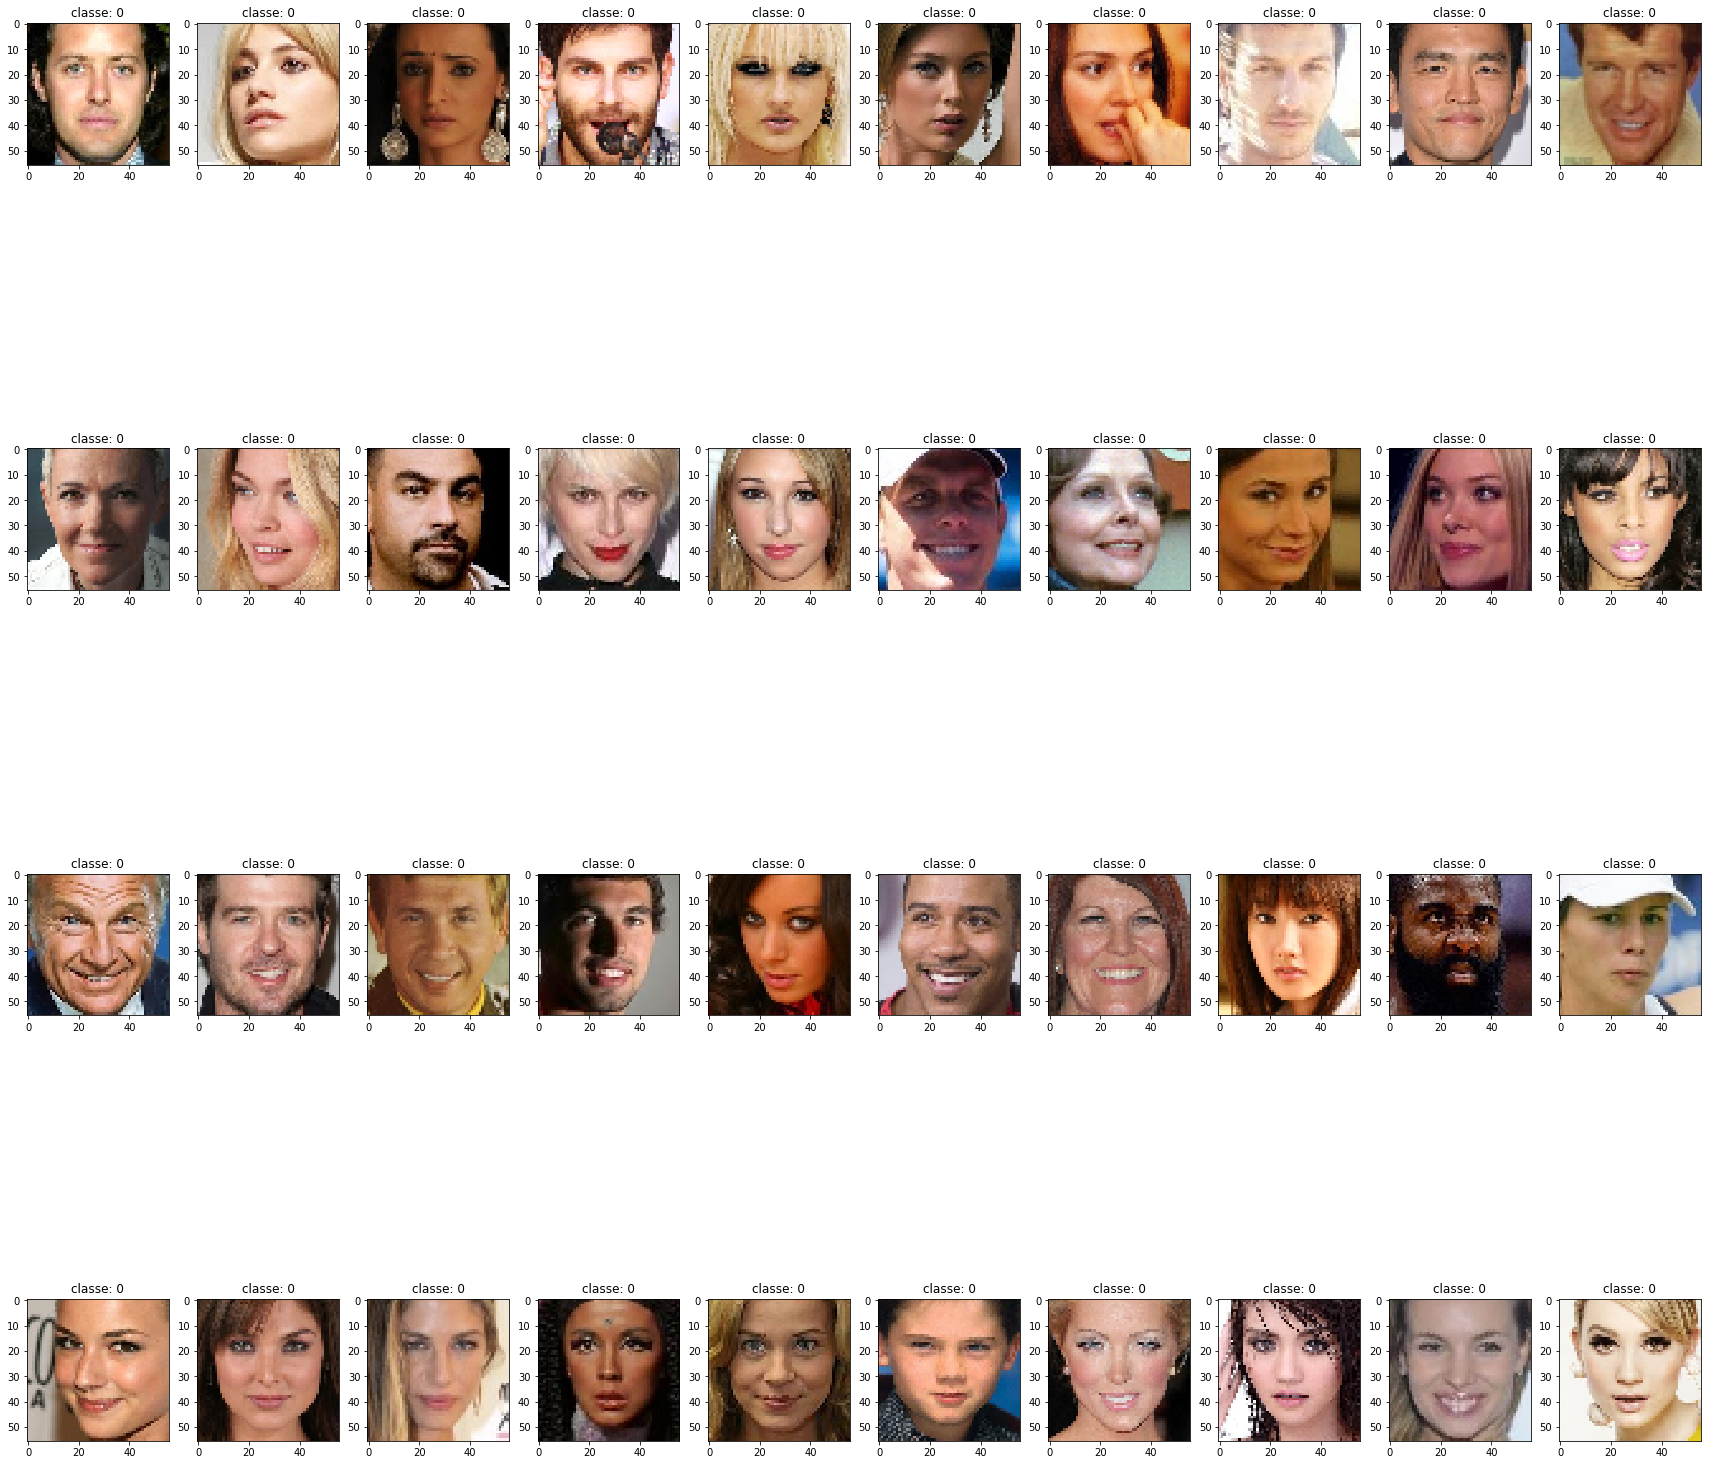

In [20]:
# afficher aleatoirement 40 image 
fig=plt.figure(figsize=(30, 30))
for i in range(1,41,1):
    # choisir aleatoirement des images a affichier
    randint = np.random.randint(0, 15250)
    fig.add_subplot(4, 10, i)
    plt.title( 'classe: 0')
    plt.imshow( zeros[randint] )
plt.show()


# DATA PROCESSING 

In [14]:
# matching entre les labels et les images et les mettre dans la même variable
data_zeros = [ (np.asarray( faces_map[i] ), 0) for i in range( len( faces_map ) - 1) if data_labels_list[i] == 0 ]
data_ones = [ (np.asarray( faces_map[i] ), 1) for i in range( len( faces_map ) - 1) if data_labels_list[i] == 1 ]

number_of_ones = len( data_zeros )
number_of_zeros = len( data_ones )
print("number_of_ones: ", number_of_ones )
print("number_of_zeros: ", number_of_zeros )

number_of_ones:  15250
number_of_zeros:  96179


#### imbalance data

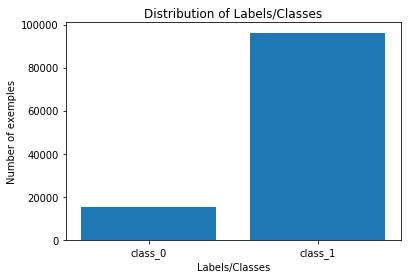

In [15]:
n_class_0 = len( data_zeros)  
n_class_1 = len( data_ones) 
y = np.array([n_class_0, n_class_1])
plt.bar(['class_0','class_1'], y)
plt.xlabel('Labels/Classes')
plt.ylabel('Number of exemples')
plt.title('Distribution of Labels/Classes')
plt.show()

In [16]:
# dû ou problème memoire on restreind la data d'apprentissage a la taille de data Zeros
data_ones = data_ones[ :len(data_zeros) ]
# repartition de data 
test_data = data_zeros[:2000] + data_ones[:2000]
validation_data = data_zeros[2000:4000] + data_ones[2000:4000]
train_data = data_zeros[4000:] + data_ones[4000:]

In [17]:
def get_shuffle( data ):
    "shuffle data randomly"
    shuffled_data = []
    Length = len( data ) 
    N = Length
    dupplicate = []
    for i in range( N ):
        randint = np.random.randint(i, Length)
        if randint not in dupplicate:
            shuffled_data.append( data[randint])
        else:
            dupplicate.append( randint )
            N += 1
    return  shuffled_data

In [18]:
# shuffle la data d'entrainement
train_shuffled = get_shuffle( train_data )
train_images = [train_shuffled[i][0] for i in range(len(train_shuffled)) ] 
train_labels  = [train_shuffled[i][1] for i in range(len(train_shuffled)) ] 

# shuffle la data de test
test_shuffled = get_shuffle( test_data )
test_images = [ test_shuffled[i][0] for i in range( len( test_shuffled )) ]
test_labels = [ test_shuffled[i][1] for i in range( len( test_shuffled )) ]

# shuffle la data de validation
validation_shuffled = get_shuffle( validation_data )
validation_images = [ validation_shuffled[i][0] for i in range( len( validation_shuffled )) ]
validation_labels = [ validation_shuffled[i][1] for i in range( len( validation_shuffled )) ]

# convertir les listes en array 
train_images_array = np.asarray( train_images )
train_labels_array = np.asarray( train_labels )

test_images_array = np.asarray( test_images )
test_labels_array = np.asarray( test_labels )

validation_images_array = np.asarray( validation_images )
validation_labels_array = np.asarray( validation_labels )

# DATA GENERATORS 

In [19]:
# les ImageDataGenerator permet de traiter les images pour les NN 
# et utiliser l'angmentation de la data facilement
from keras.preprocessing.image import ImageDataGenerator 
train_datagen = ImageDataGenerator( rescale = 1./255,
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range=0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip=True,
                fill_mode = 'nearest')
# la data de test et validation ne seront pas augmenté
test_datagen = ImageDataGenerator( rescale = 1./255 )
validation_datagen = ImageDataGenerator( rescale = 1./255 )

train_generator = train_datagen.flow( train_images_array, train_labels_array , batch_size = 20 )
validation_generator = test_datagen.flow(test_images_array, test_labels_array, batch_size = 20 )
test_generator = validation_datagen.flow(validation_images_array, validation_labels_array, batch_size = 20 )

# MODEL CONSTRUCTION with KERAS

In [20]:
main_model = Sequential()
main_model.add( Conv2D( 32, (3, 3), activation = 'relu', input_shape = (56, 56, 3)))
main_model.add( MaxPooling2D((2, 2)))
main_model.add( Conv2D( 64, (3, 3), activation = 'relu'))
main_model.add( MaxPooling2D((2, 2)))
main_model.add( Conv2D( 128, (3, 3), activation = 'relu'))
main_model.add( MaxPooling2D((2, 2)))
main_model.add( Conv2D( 128, (3, 3), activation = 'relu'))
main_model.add( MaxPooling2D((2, 2)))
main_model.add( Flatten())
main_model.add( Dropout(0.5))
main_model.add( Dense(512, kernel_regularizer = regularizers.l2(0.001) , activation = 'relu'))
main_model.add( Dense(1, activation = 'sigmoid' ))
main_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         147584    
__________

# TRAINING THE MODEL

In [110]:
main_model.compile( optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'] )

main_model_history = main_model.fit_generator(train_generator,
                                         steps_per_epoch = 50, epochs = 5, 
                                         validation_data = validation_generator,
                                         validation_steps = 20)

Epoch 1/5
50/50 [==============================] - 8s 162ms/step - loss: 0.6083 - acc: 0.8430 - val_loss: 0.5947 - val_acc: 0.8150
Epoch 2/5
50/50 [==============================] - 7s 133ms/step - loss: 0.5200 - acc: 0.8430 - val_loss: 0.6244 - val_acc: 0.8250
Epoch 3/5
50/50 [==============================] - 7s 134ms/step - loss: 0.4797 - acc: 0.8500 - val_loss: 0.4723 - val_acc: 0.8375
Epoch 4/5
50/50 [==============================] - 7s 143ms/step - loss: 0.4365 - acc: 0.8630 - val_loss: 0.4774 - val_acc: 0.8350
Epoch 5/5
50/50 [==============================] - 7s 136ms/step - loss: 0.4550 - acc: 0.8440 - val_loss: 0.4529 - val_acc: 0.8475


In [111]:
model_predictions = main_model.evaluate(test_images_array, test_labels_array )
model_predictions

4000/4000 [==============================] - 8s 2ms/step


[2.5454276535660028, 0.841]

# Training visualisation

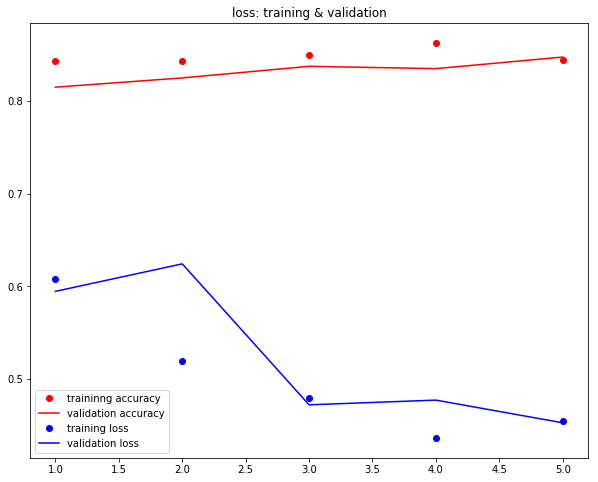

In [112]:
plt.figure(figsize =(10,8))
acc = main_model_history.history['acc']
val_acc = main_model_history.history['val_acc']

loss = main_model_history.history['loss']
val_loss = main_model_history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot( epochs, acc, 'bo',color = 'r', label = 'traininng accuracy')
plt.plot( epochs, val_acc, 'b',color = 'r', label = 'validation accuracy')

plt.plot( epochs, loss, 'bo',color = 'b', label = 'training loss')
plt.plot( epochs, val_loss, 'b',color = 'b', label = 'validation loss')
plt.title("loss: training & validation")
plt.legend()
plt.show()

# PREDICT TESTSET WITH MAIN_MODEL

In [76]:
db_test_path = base_dir + 'db_test.raw'
# ouvrir le fichier raw
db_test = open(db_test_path , 'rb')
# lire le fichier rbinaire 
db_test_read = db_test.read()
# utiliser memory-map pour stocker le contenu bin
faces_test = np.memmap(db_test_path, dtype=np.uint8, shape = (10130, 56, 56, 3) )
faces_test_array = np.asarray( faces_test )
test_prediction = main_model.predict( faces_test_array )
len(test_prediction)

# TRANSFERT LEARNING with VGG16

In [11]:
from keras.applications import VGG16
# utilisation de model VGG16 pre-entrainé sur imagenet 
vgg16_model = VGG16( weights = 'imagenet', include_top = False, input_shape = (56,56,3))
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0         
__________

In [14]:
# extraction des features a partir de vgg16 pre-entrainé 
datagen = ImageDataGenerator()
def extract_features_from_vgg16(data_x, data_y):
    "cette fonction extrait les resultats tensors des couches de VGG16"
    batch_size = 10
    features = np.zeros((len(data_x), 1, 1, 512))
    labels = np.zeros((len(data_x)))
    data_generator = datagen.flow(data_x, data_y, batch_size = batch_size)
    i = 0
    for input_batch, label_batch in data_generator:
        # pour chaque entre vgg16_model predit le tensor des features sortit 
        features_batch = vgg16_model.predict( input_batch )
        features[i * batch_size: ( i + 1 ) * batch_size] = features_batch
        labels[i * batch_size: ( i + 1 ) * batch_size] = label_batch
        i += 1
        if i * batch_size >= len( data_x ):
            break
    return features, labels

### extract features from vgg16 pretrained on imagenet dataset

In [15]:
# extraire les features de la data d'entrainement
trained_train_features, trained_train_labels = extract_features_from_vgg16( train_images_array,
                                                                          train_labels_array)
# extraire les features de la data de test
trained_test_features, trained_test_labels = extract_features_from_vgg16( test_images_array,
                                                                          test_labels_array)
# extraire les features de la data de validation
trained_validation_features, trained_validation_labels = extract_features_from_vgg16( validation_images_array,
                                                                          validation_labels_array)

In [17]:
# juste in case better work on this sample than the others
trained_train_features_, trained_train_labels_ = trained_train_features, trained_train_labels
trained_test_features_, trained_test_labels_ = trained_test_features, trained_test_labels
trained_validation_features_, trained_validation_labels_ = trained_validation_features, trained_validation_labels

In [34]:
# the classifier 
# la partie final non entrainé sur le modela rajouté au top de VGG16
classifier_model = Sequential()
classifier_model.add( Dense(265, activation = 'relu', input_dim =1*1*512))
classifier_model.add( Dropout(0.5))
classifier_model.add( Dense(1, activation = 'sigmoid'))

classifier_model.compile( optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'] )

In [36]:
# reshaping
trained_train_features_ = np.reshape(trained_train_features_, (len( trained_train_features_ ),1 * 1 * 512))
trained_test_features_ = np.reshape(trained_test_features_, (len( trained_test_features_ ), 1 * 1 * 512))
trained_validation_features_ = np.reshape(trained_validation_features_, (len( trained_validation_features_ ), 1 * 1 * 512))

classifier_history = classifier_model.fit(trained_train_features_, trained_train_labels_,
                                         epochs = 20, batch_size = 10, 
                                         validation_data = (trained_validation_features_, trained_validation_labels_))

Train on 22500 samples, validate on 4000 samples
Epoch 1/20
22500/22500 [==============================] - 9s 411us/step - loss: 2.4463 - acc: 0.8427 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 2/20
22500/22500 [==============================] - 9s 418us/step - loss: 2.4530 - acc: 0.8461 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 3/20
22500/22500 [==============================] - 8s 351us/step - loss: 2.4530 - acc: 0.8461 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 4/20
22500/22500 [==============================] - 8s 358us/step - loss: 2.4530 - acc: 0.8461 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 5/20
22500/22500 [==============================] - 9s 385us/step - loss: 2.4530 - acc: 0.8461 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 6/20
22500/22500 [==============================] - 8s 337us/step - loss: 2.4530 - acc: 0.8461 - val_loss: 2.4830 - val_acc: 0.8442
Epoch 7/20
22500/22500 [==============================] - 9s 396us/step - loss: 2.4529 - acc: 0.8461 - val_loss: 2.4830 - v

In [48]:
classifier_model_evaluation = classifier_model.evaluate(trained_test_features_, trained_test_labels_)
classifier_model_evaluation

4000/4000 [==============================] - 0s 48us/step


[2.5348393011093155, 0.841]

# UNDERSTANDING THE MODEL OUTPUT 

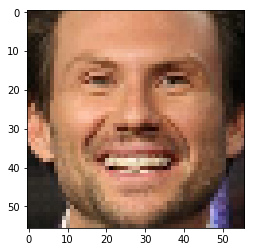

In [132]:
# prendre que les 8 premiers couche de main_model
layers_output = [ layer.output for layer in main_model.layers[:8] ]
activation_model = models.Model( inputs = main_model.input, outputs = layers_output )
# choisir une image aleatoire par exemple: 34
face_from_test = faces_test_array[34]
img_tensor = np.expand_dims(face_from_test ,axis = 0)
img_tensor = img_tensor.astype('float32') / 255
plt.imshow(img_tensor[0])
plt.show()

###### affichier les differents channel de premiers couche de main_model

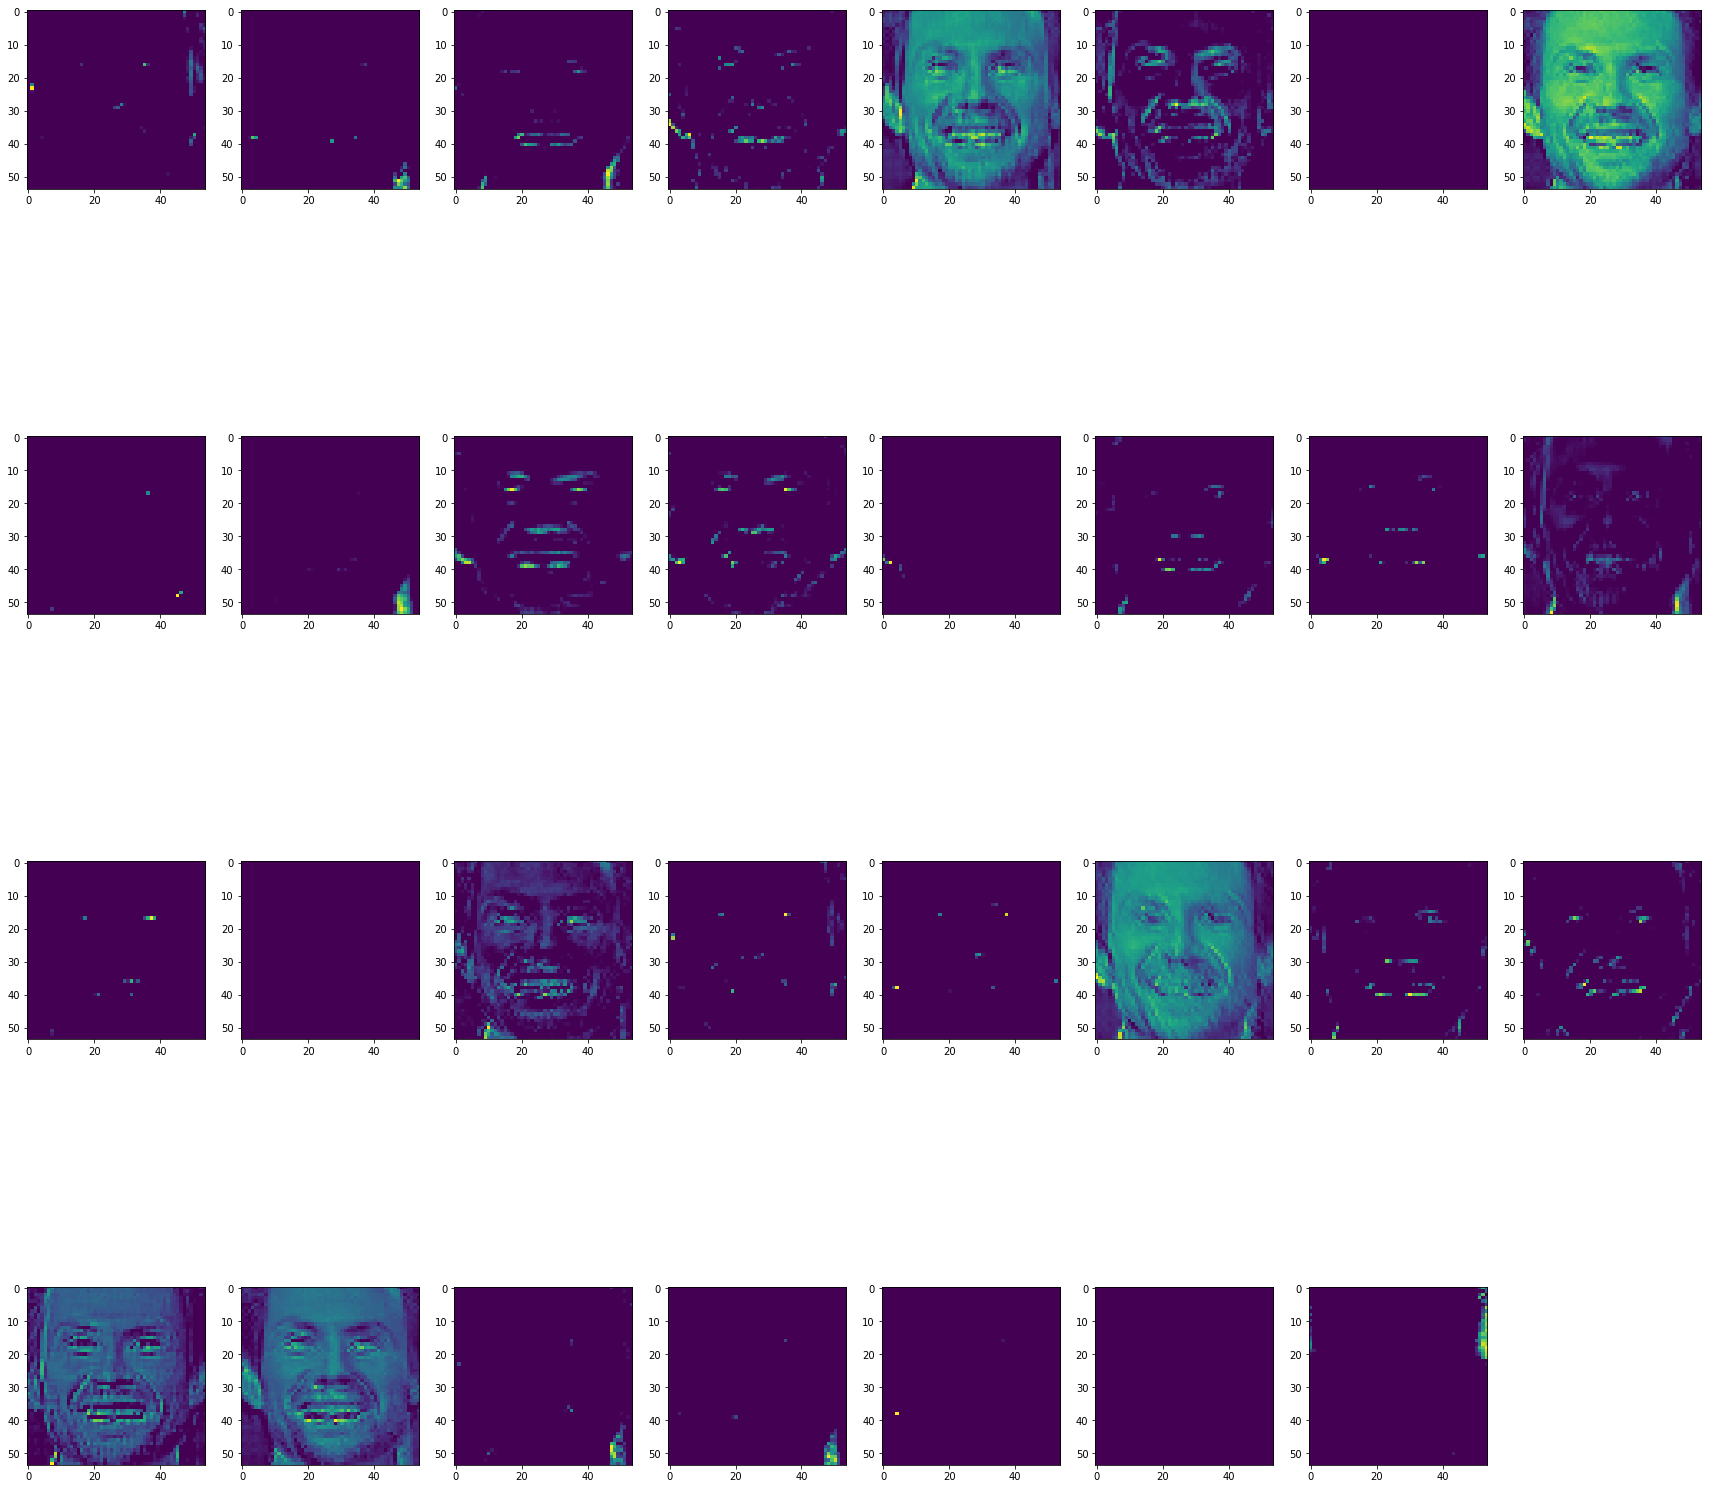

In [138]:
activations = activation_model.predict( img_tensor )
first_layer = activations[0]

fig=plt.figure(figsize=(30, 30))
for i in range(1,first_layer.shape[-1],1):
    randint = np.random.randint(0, 111430)
    fig.add_subplot(4, 8, i)
    plt.imshow( first_layer[0, :, : ,i] )
plt.show()

/home/reda/anaconda3/envs/tensorflow_tutos/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


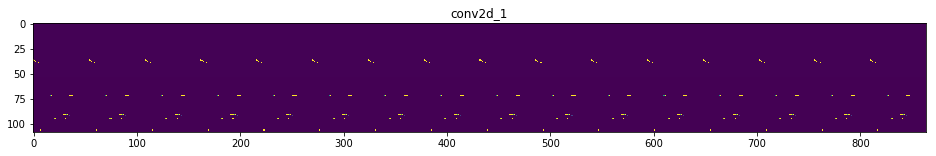

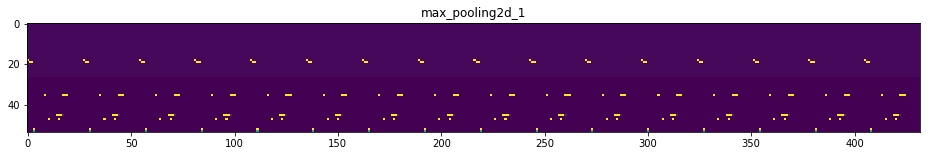

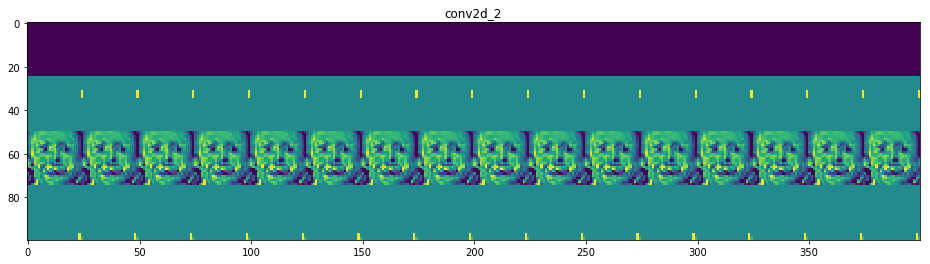

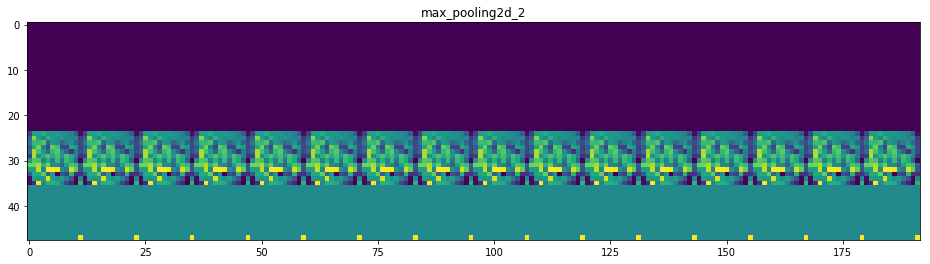

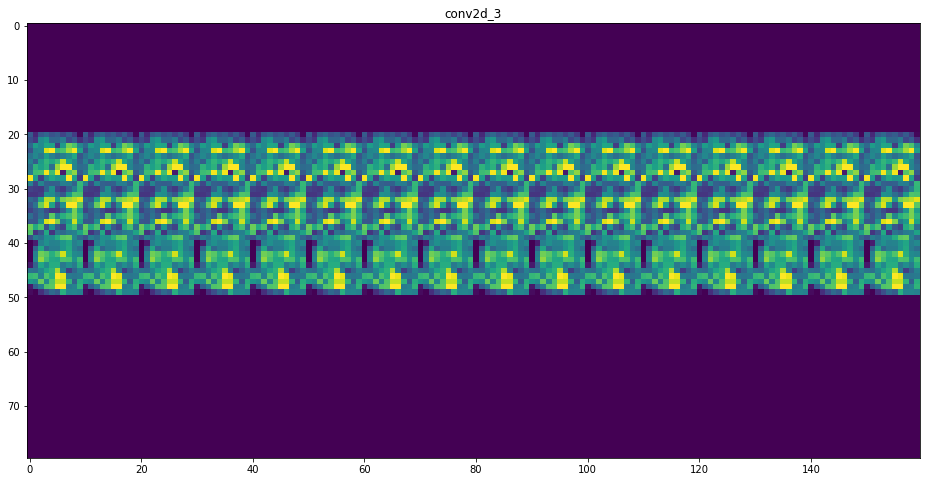

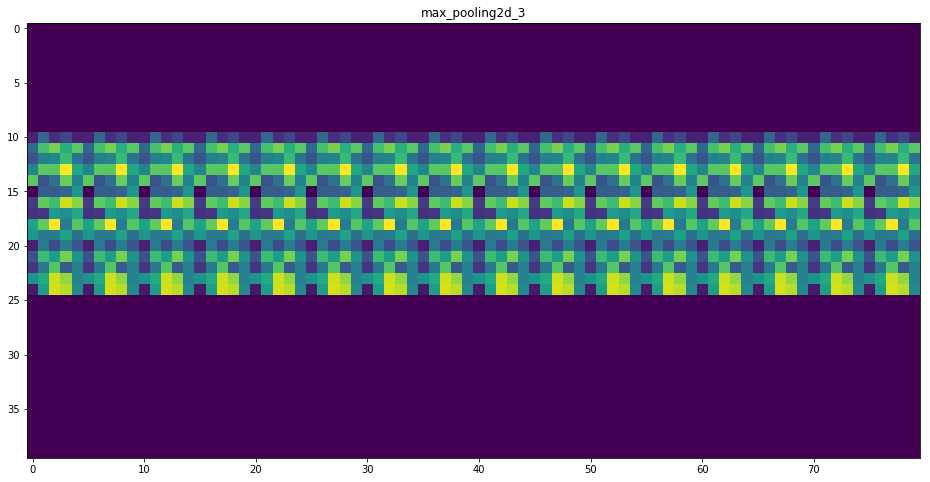

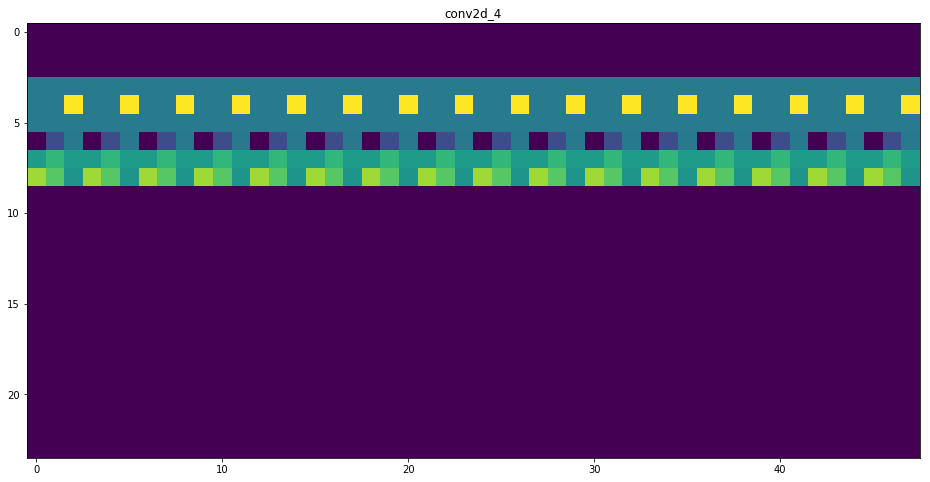

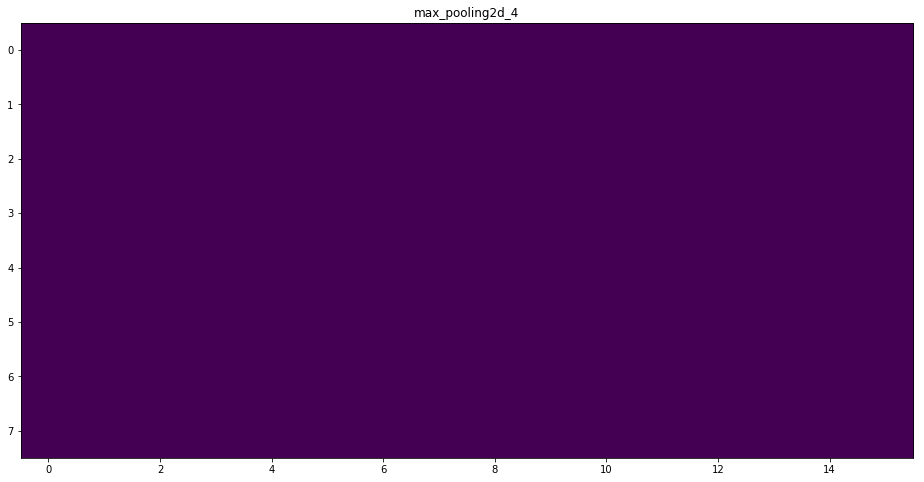

In [139]:
# ploting tous channel et filters sortit par les couches de main_model
layer_names = []
for layer in main_model.layers[:8]:
    "extraire les nom des couches"
    layer_names.append(layer.name)
    
image_per_row = 16

for layer_name, layer_activation in zip( layer_names, activations):
    "pour chaque couche extraire les filtres & channels et les afficher par nom de couche"
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // image_per_row
    
    display_grid = np.zeros((size * n_cols, size * image_per_row))
    
    for col in range( n_cols ):
        for row in range( image_per_row ):
            chanel_image = layer_activation[0, :, :, col * image_per_row + col]
            chanel_image -= chanel_image.mean()
            chanel_image /= chanel_image.std()
            chanel_image *= 64
            chanel_image += 128
            chanel_image = np.clip(chanel_image ,0, 255).astype("uint8")
            display_grid[ col * size : ( col + 1) * size, row * size : ( row + 1) * size ] = chanel_image 
            
    scale = 1./size
    plt.figure( figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0] ))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow( display_grid, aspect = 'auto', cmap = 'viridis')
    